# A Q-Learning Agent for the Simple Classroom Environment Example

The following notebook uses a simple Q-Learning agent with episodic experience to find an optimal policy for the Classroom previously defined.

I have set some extra challenges at the end I suggest you try to complete in your own time.

Please let me know if you have any questions.



In [1]:
# Import environment from Environment.ipynb by copying final cell

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

from IPython.display import clear_output
from IPython import display

import time

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15, 10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})

sns.set_style("whitegrid", {'axes.grid' : False})

#------------------------------------------------------------------------------------------

states = ['A','B','C','D','E','F','G','T','M','recycling','trash']
x_list = [4,3,2,1,1,1,2,3,3,4,4]
y_list = [1,1,1,1,2,3,3,3,2,3,2]

# The low-level actions the agent can make in the environment
actions = ['left','right','up','down']
rewards = [-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,-0.04,1,-1]

#initial_policy = ['left','up','right','up','up','right','right','right','up','up','up']

#------------------------------------------------------------------------------------------

def action_outcome(state_x,state_y,action):
    if action == 'left':
        u = -1
        v = 0
    elif action == 'right':
        u = 1
        v = 0
    elif action == 'up':
        u = 0
        v = 1
    elif action == 'down':
        u = 0
        v = -1
    else:
        print("Error: Invalid action given")
        
    # Override if action hits wall to not move
    if (state_x == 1) & (u == -1):
        u = 0
        v = v
    elif (state_x == 4) & (u == 1):
        u = 0
        v = v
    elif (state_y == 1) & (v == -1):
        u = u
        v = 0
    elif (state_y == 3) & (v == 1):
        u = u
        v = 0
    elif (state_x == 2)&(state_y == 1) & (v == 1):
        u = u
        v = 0
    elif (state_x == 1)&(state_y == 2) & (u == 1):
        u = 0
        v = v  
    elif (state_x == 2)&(state_y == 3) & (v == -1):
        u = u
        v = 0         
    elif (state_x == 3)&(state_y == 2) & (u == -1):
        u = 0
        v = v 
    # Make so it cannot get out of bin
    elif (state_x == 4)&(state_y == 3):
        u = 0
        v = 0
    elif (state_x == 4)&(state_y == 2):
        u = 0
        v = 0
    return(u,v)

def environment(state, action):
    # Outcome probabilities
    if (state=='recycling')|(state=='trash'):
        prob = 0
    elif (state=='T'):
        prob = 1

    elif (state=='M'):
        prob = 0.7
   
    elif (state=='B'):
        prob = 0.7

    elif (state=='A'):
        prob = 0.7

    elif (state=='C'):
        prob = 0.7

    elif (state=='D'):
        prob = 0.7

    elif (state=='E'):
        prob = 0.7

    elif (state=='F'):
        prob = 0.7

    elif (state=='G'):
        prob = 0.7

    else:
        prob = "Error"
        print("Error state", state)

    action_rng = np.random.rand()
    if action_rng<=prob:
        action = action
    else:
        action_sub_list = actions.copy()
        action_sub_list.remove(action)
        action = random.choice(action_sub_list)
        
        
    state_x = x_list[states.index(state)]
    state_y = y_list[states.index(state)]
    u = action_outcome(state_x,state_y,action)[0]
    v = action_outcome(state_x,state_y,action)[1]
    next_state_x = state_x + u
    next_state_y = state_y + v
    # Returns index of x + y position to then find the state name
    next_state = states[' '.join(str(x_list[i])+ "_" + str(y_list[i]) for i in range(0,len(x_list))).split().index(str(next_state_x) + "_" + str(next_state_y))]
    reward = rewards[states.index(next_state)]
    return(state, action, state_x, state_y, u, v, next_state, next_state_x, next_state_y, reward)

#------------------------------------------------------------------------------------------


### Q-Learning Update

$Q(s,a) \leftarrow (1-\alpha)*Q(s_{t},a_{t}) + \alpha[r + \gamma max_a(Q(s_{t+1},a))]$

Which can be expanded to:

$Q(s,a) \leftarrow  Q(s_{t},a_{t}) + \alpha[ r + \gamma max_a(Q(s_{t+1},a)) - Q(s_{t},a_{t})]$

where $\alpha$ is the learning rate and $\gamma$ is the discount parameter.


In [2]:
def Q_learning_v1(Q_table, start_state, num_episodes, epsilon, num_random_episodes, alpha, gamma):
    
    Q_value_tracker = pd.DataFrame()
    for episode in range(0,num_episodes):
        clear_output(wait=True)
        display.clear_output(wait=True)
        print("Episodes Completed: ", np.round( (episode/num_episodes)*100,2),"%")
        
        # Add this so start state doesn't need to be given by user input
        if (start_state is None):
            state = random.choice(states)
        else:
            state = start_state
            
        # Initialise action loop    
        a = 1
        while True:
            # End loop at terminal states
            if (state == 'recycling')|(state == 'trash'):
                break
            else:
                # Apply epsilon-greedy
                #------
                # We set first few episodes to follow purely randomly selection for exploration
                greedy_rng = np.random.rand()
                if (episode<num_random_episodes):
                    action = random.choice(actions)
                # Randomly select with P=epsilon
                elif (greedy_rng <= epsilon):
                    action = random.choice(actions)
                # Greedy (max value currently) otherwise 
                else:
                    # Pick action in state with highest Q value, randomly select if multiple match same max value
                    Q_table_max = Q_table[Q_table['Q'] == max(Q_table['Q'])]
                    if len(Q_table_max)>1:
                        action = Q_table_max.sample().iloc[0]['action']
                    else:
                        action = Q_table_max.iloc[0]['action']
                #------
                
                
                # Environment probabilistric outcome
                #---
                # environment fn output: return(state, action, state_x, state_y, u, v, next_state, next_state_x, next_state_y, reward)
                outcome = environment(state, action)
                
                new_state = outcome[6]
                new_x = outcome[7]
                new_y = outcome[8]
                r = outcome[9]
                #------
                
                
                # Update Values
                #------
                # Update Q based on episode outcome
                # Q learning update: Q(s_{t},a_{t}) <-- (1-alpha)*Q(s_{t},a_{t}) + alpha[r + gamma*max(Q(s_{t+1},a))]
                Q_table_new_state = Q_table[Q_table['state']==new_state]
                max_Q_new_state = Q_table_new_state[Q_table_new_state['Q'] == max(Q_table_new_state['Q'])].iloc[0]['Q']
                
                Q_table['Q'] = np.where( (Q_table['state']==state)&(Q_table['action']==action), 
                                        ((1-alpha)*Q_table['Q']) + (alpha*(r + (gamma*max_Q_new_state))),
                                        Q_table['Q'] )
                #------
                
                # Move to next action, make the new state the current state
                #------
                a=a+1
                state=new_state
                #------
        """     
        # Optimal Policy Plot - REMOVE THIS IF YOU WANT IT TO RUN FASTER FOR FINAL OUTPUT
        #------
        # Plot best actions in each state

        Q_table['Q_norm'] = (Q_table['Q']-min(Q_table['Q']))/( max(Q_table['Q']) - min(Q_table['Q']) )
        for n,state in enumerate(states):
            if state == 'recycling':
                plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
            elif state == 'trash':
                plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
            else:
                plt.scatter(x_list[n],y_list[n], s=150, color='b')
            plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
            Q_table_output_state = Q_table[Q_table['state']==state].reset_index(drop=True)
            for action in range(0,len(Q_table_output_state)):
                if (Q_table_output_state['Q_norm'].iloc[action] == Q_table_output_state['Q_norm'].max()):
                    plt.quiver(x_list[n],y_list[n],Q_table_output_state['u'][action],Q_table_output_state['v'][action], alpha = 0.5,
                              width = 0.01*Q_table_output_state['Q_norm'][action])

        plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Optimal Action for each State")
        plt.xticks([])
        plt.yticks([])
        plt.ylim(0,4)
        plt.xlim(0,5)
        plt.show()
        time.sleep(2.0)
        #------
        """
        Q_value_tracker = Q_value_tracker.append(pd.DataFrame({'episode':episode, 'mean_Q': Q_table['Q'].mean(),'total_Q':Q_table['Q'].sum()}, index=[episode]))
        
    return(Q_table, Q_value_tracker)

In [3]:
# Initialise RL flat agent

## Fix episode start if running on small scale for understanding
start_state = None

## Parameters
num_episodes = 500
epsilon = 0.2
num_random_episodes = 50
alpha = 0.2
gamma = 0.8

In [4]:
# Initialise Q Values equal to 0
Q_table = pd.DataFrame()
for n1,state in enumerate(states):
    action_list = pd.DataFrame()
    for n2,action in enumerate(actions):
        state_x = x_list[n1]
        state_y = y_list[n1]
        u = action_outcome(state_x,state_y,action)[0]
        v = action_outcome(state_x,state_y,action)[1]
        action_list  = action_list.append(pd.DataFrame({'state':state,'x':x_list[n1],'y':y_list[n1],'u':u,'v':v, 'action':action}, index=[(n1*len(actions)) + n2]))

    Q_table = Q_table.append(action_list)
Q_table['Q']=0

In [5]:
Q_table.head()

,state,x,y,u,v,action,Q
0,A,4,1,-1,0,left,0
1,A,4,1,0,0,right,0
2,A,4,1,0,1,up,0
3,A,4,1,0,0,down,0
4,B,3,1,-1,0,left,0


In [6]:
Mdl = Q_learning_v1(Q_table, start_state, num_episodes, epsilon, num_random_episodes, alpha, gamma)
Q_table_output = Mdl[0]
Q_table_tracker_output = Mdl[1]

Episodes Completed:  99.8 %


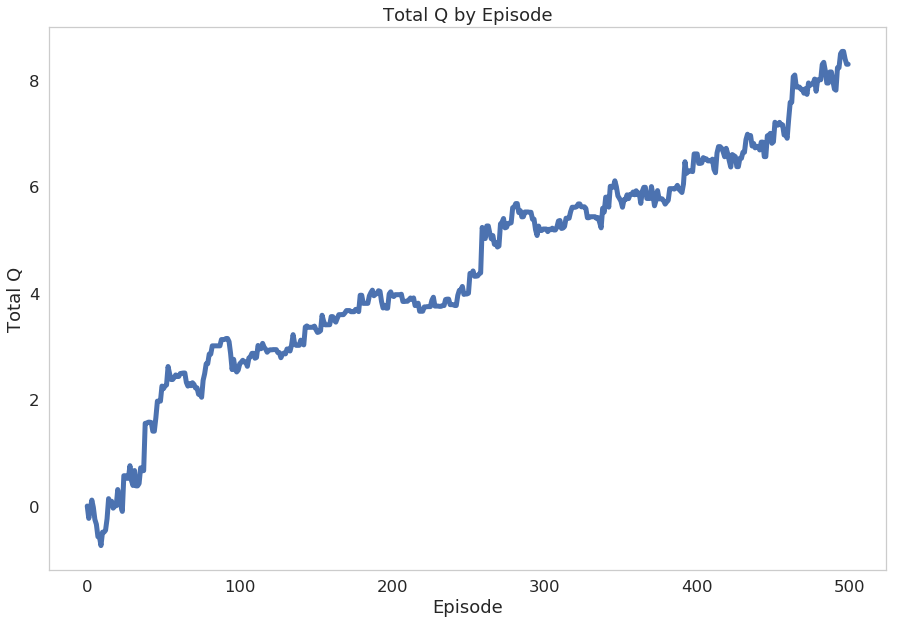

In [7]:
plt.plot(Q_table_tracker_output['total_Q'])
plt.ylabel("Total Q")
plt.xlabel("Episode")
plt.title("Total Q by Episode")
plt.show()

In [8]:
# Normalise so we can still plot negative values
Q_table_output['Q_norm'] = (Q_table_output['Q']-min(Q_table_output['Q']))/( max(Q_table_output['Q']) - min(Q_table_output['Q']) )
Q_table_output.head(50)

,state,x,y,u,v,action,Q,Q_norm
0,A,4,1,-1,0,left,0.042843,0.419033
1,A,4,1,0,0,right,0.064099,0.431935
2,A,4,1,0,1,up,-0.647523,0.000000
3,A,4,1,0,0,down,0.051188,0.424098
4,B,3,1,-1,0,left,0.094773,0.450553
5,B,3,1,1,0,right,0.182855,0.504016
6,B,3,1,0,1,up,0.431313,0.654823
7,B,3,1,0,0,down,0.272045,0.558152
8,C,2,1,-1,0,left,0.044003,0.419737
9,C,2,1,1,0,right,0.249452,0.544439


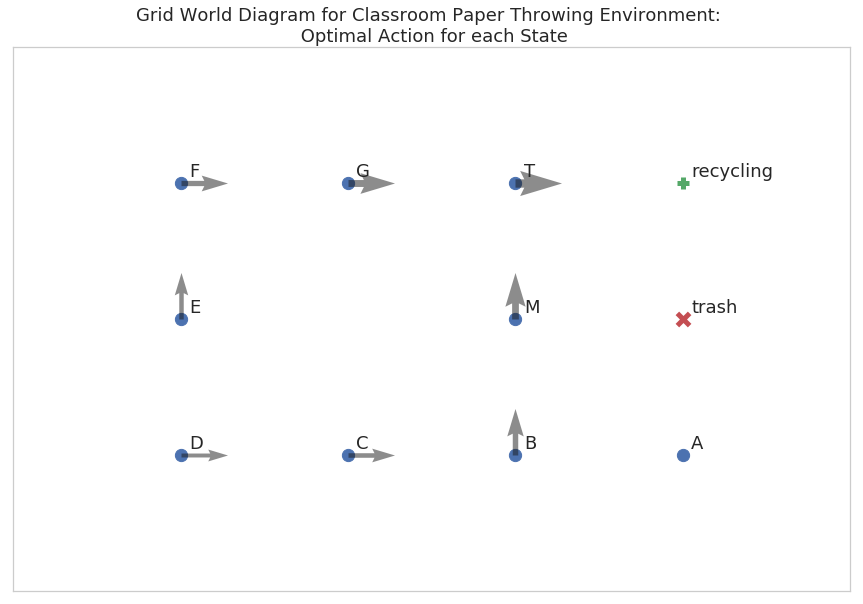

In [9]:
# Plot best actions in each state
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
    Q_table_output_state = Q_table_output[Q_table_output['state']==state].reset_index(drop=True)
    for action in range(0,len(Q_table_output_state)):
        if (Q_table_output_state['Q_norm'].iloc[action] == Q_table_output_state['Q_norm'].max()):
            plt.quiver(x_list[n],y_list[n],Q_table_output_state['u'][action],Q_table_output_state['v'][action], alpha = 0.5,
                      width = 0.01*Q_table_output_state['Q_norm'][action])
    
plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Optimal Action for each State")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()


# Next Steps

## Part 1: Understand Algorithms

1. Apply TD(0) update approach
2. Apply Monte Carlo update approach
3. Apply SARSA update approach
4. Compare learning patterns between each method

## Part 2: Understand Paramters

1. Vary the Learning Rate $\alpha$
2. Vary the Discount Rate $\gamma$
3. Vary the Action Selection parameter $\epsilon$

## Part 3: Environmental Changes

1. Change the probabilities of students following the command (e.g. Make "M" less likely to follow command)
2. Vary the Reward Signal to see how this effects learning, what happens if we dont use r=-0.04 for all actions and instead use r=0
